In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import warnings; warnings.simplefilter('ignore')

# Popularity Based Recommender


In [74]:
movies_df = pd. read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [75]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [76]:
# Filling missing values in 'genres' column with empty list
movies_df['genres'] = movies_df['genres'].fillna('[]')

# Using literal_eval to safely evaluate string representation of a list
movies_df['genres'] = movies_df['genres'].apply(literal_eval)

# Using lambda function to extract 'name' field from each dictionary in the list
movies_df['genres'] = movies_df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [77]:
C = movies_df['vote_average'].mean()
C

5.618207215134185

In [78]:
m = movies_df['vote_count'].quantile(0.95)
m

434.0

In [79]:
# Convert 'release_date' column to datetime and extract the year
movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year

# Convert 'year' column to integers
movies_df['year'] = movies_df['year'].astype('Int64')

# Display descriptive statistics of the 'year' column
print(movies_df['year'].describe())

count        45376.0
mean     1991.881193
std         24.05536
min           1874.0
25%           1978.0
50%           2001.0
75%           2010.0
max           2020.0
Name: year, dtype: Float64


In [80]:
qualified_movies = movies_df[(movies_df['vote_count'] >= m)][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

# Convert 'vote_count' and 'vote_average' to integers
qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
qualified_movies['year']= qualified_movies['year'].astype('int')
qualified_movies.shape

(2274, 6)

In [81]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [82]:
qualified_movies['weighted_rating'] = qualified_movies.apply(weighted_rating, axis=1)

In [83]:
qualified_movies = qualified_movies.sort_values('weighted_rating', ascending=False).head(250)
qualified_movies.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.928755
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.918626
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.911049
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.897775
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.889160
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.886457
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.882427
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.880635
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.879536
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.871988


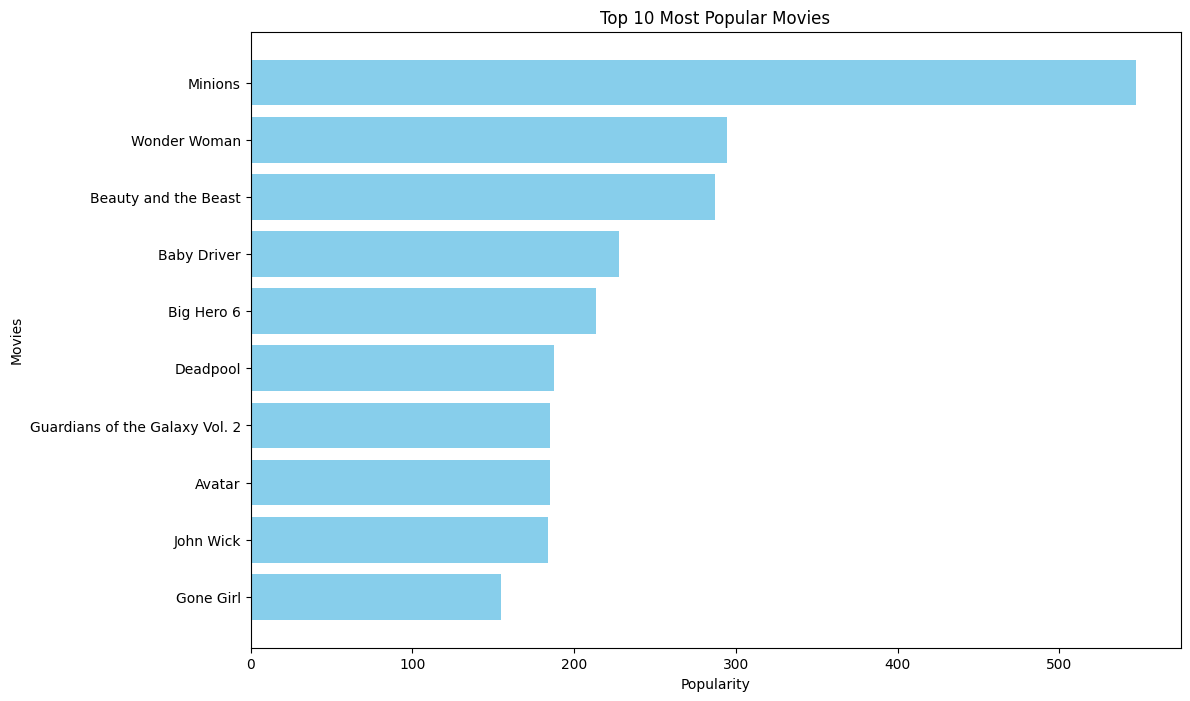

In [84]:
import matplotlib.pyplot as plt

# Convert 'popularity' column to numeric format
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce')

# Remove rows with NaN values in the 'popularity' column
movies_df = movies_df.dropna(subset=['popularity'])

# Sort the DataFrame by popularity in descending order
pop = movies_df.sort_values('popularity', ascending=False)

# Create a bar plot for the top 10 most popular movies
plt.figure(figsize=(12, 8))
plt.barh(pop['title'].head(10), pop['popularity'].head(10), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.ylabel("Movies")
plt.title("Top 10 Most Popular Movies")
plt.show()


In [85]:
def build_chart(genre, percentile=0.85):
    """
    Builds a chart for a particular genre based on movies.

    Parameters:
        genre (str): The genre to filter movies by.
        percentile (float, optional): The percentile value for minimum vote count. Default is 0.85.

    Returns:
        pd.DataFrame: DataFrame containing top-rated movies of the specified genre.
    """
    # Create a DataFrame with each genre in a separate row
    s = movies_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'genre'
    gen_md = movies_df.drop('genres', axis=1).join(s)

    # Filter movies by the specified genre
    df = gen_md[gen_md['genre'] == genre]
    
    # Calculate C, the mean vote across the whole report
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    
    # Calculate m, the minimum votes required to be listed in the chart
    m = vote_counts.quantile(percentile)
    
    # Filter qualified movies based on vote count and average
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    # Calculate the weighted rating for each movie
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    
    # Sort movies based on weighted rating in descending order and select top 250
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified


In [86]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.208220,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [87]:
build_chart('Action').head(15)

,title,year,vote_count,vote_average,popularity,wr
15480,Inception,2010,14075,8,29.108149,7.955099
12481,The Dark Knight,2008,12269,8,123.167259,7.948610
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.929579
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.924031
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.918382
256,Star Wars,1977,6778,8,42.149697,7.908327
1154,The Empire Strikes Back,1980,5998,8,19.470959,7.896841
4135,Scarface,1983,3017,8,11.299673,7.802046
9430,Oldboy,2003,2000,8,10.616859,7.711649
1910,Seven Samurai,1954,892,8,15.017770,7.426145


# Content Based Recommender

In [88]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45460 entries, 0 to 45465
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45460 non-null  object 
 1   belongs_to_collection  4490 non-null   object 
 2   budget                 45460 non-null  object 
 3   genres                 45460 non-null  object 
 4   homepage               7778 non-null   object 
 5   id                     45460 non-null  object 
 6   imdb_id                45443 non-null  object 
 7   original_language      45449 non-null  object 
 8   original_title         45460 non-null  object 
 9   overview               44506 non-null  object 
 10  popularity             45460 non-null  float64
 11  poster_path            45077 non-null  object 
 12  production_companies   45460 non-null  object 
 13  production_countries   45460 non-null  object 
 14  release_date           45376 non-null  object 
 15  revenue

In [89]:
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [90]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [91]:
links_small = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [92]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies_df['id'] = movies_df['id'].astype('int')

In [93]:
movies_df = movies_df.merge(credits, on='id')
movies_df = movies_df.merge(keywords, on='id')

In [94]:
# Count the number of unique movies based on the 'id' column
num_unique_movies = movies_df['id'].nunique()

# Display the result
print("Number of unique movies:", num_unique_movies)

Number of unique movies: 45429


In [95]:
movies_df = movies_df[movies_df['id'].isin(links_small)]
movies_df.shape

(9219, 28)

In [96]:
# Count the number of unique movies based on the 'id' column
num_unique_movies = movies_df['id'].nunique()

# Display the result
print("Number of unique movies:", num_unique_movies)

Number of unique movies: 9082


In [97]:
movies_df['cast'] = movies_df['cast'].apply(literal_eval)
movies_df['crew'] = movies_df['crew'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)
movies_df['cast_size'] = movies_df['cast'].apply(lambda x: len(x))
movies_df['crew_size'] = movies_df['crew'].apply(lambda x: len(x))

In [98]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [99]:
movies_df['director'] = movies_df['crew'].apply(get_director)

In [100]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,Charles Shyer


In [101]:
# Transforming 'cast' column to contain only names of the first three cast members if available
movies_df['cast'] = movies_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df['cast'] = movies_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)


In [102]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,Charles Shyer


In [103]:
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[Whitney Houston, Angela Bassett, Loretta Devine]","[{'credit_id': '52fe44779251416c91011acb', 'de...","[based on novel, interracial relationship, sin...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[Steve Martin, Diane Keaton, Martin Short]","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[baby, midlife crisis, confidence, aging, daug...",12,7,Charles Shyer


In [104]:
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director','overview']

# Replace null values with empty string for selected features
for feature in selected_features:
    movies_df[feature] = movies_df[feature].fillna('')

In [105]:
# Convert lists to strings
movies_df['cast'] = movies_df['cast'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
movies_df['genres'] = movies_df['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [106]:
# Combine all the selected features
combined_features = movies_df['overview'] + ' ' + movies_df['genres'] + ' ' + movies_df['keywords'] + ' ' + movies_df['tagline'] + ' ' +  movies_df['cast'] + ' ' + movies_df['director'] + ' ' + movies_df['director'] + ' ' + movies_df['director']
combined_features

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45981    All your favorite Pokémon characters are back,...
46420    While holidaying in the French Alps, a Swedish...
46421    While holidaying in the French Alps, a Swedish...
46422    While holidaying in the French Alps, a Swedish...
46423    While holidaying in the French Alps, a Swedish...
Length: 9219, dtype: object

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize TfidfVectorizer to convert text data into a TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

# Fit and transform the combined features into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_features)
print(tfidf_matrix.shape)

(9219, 388222)


In [108]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Display the cosine similarity matrix
print(cosine_sim)

[[1.         0.00863302 0.00893187 ... 0.006253   0.006253   0.006253  ]
 [0.00863302 1.         0.00967725 ... 0.00670088 0.00670088 0.00670088]
 [0.00893187 0.00967725 1.         ... 0.0067068  0.0067068  0.0067068 ]
 ...
 [0.006253   0.00670088 0.0067068  ... 1.         1.         1.        ]
 [0.006253   0.00670088 0.0067068  ... 1.         1.         1.        ]
 [0.006253   0.00670088 0.0067068  ... 1.         1.         1.        ]]


In [109]:
movies_df = movies_df.reset_index()
titles = movies_df['title']
indices = pd.Series(movies_df.index, index=movies_df['title'])

In [125]:
import difflib

def get_recommendations(title):
    close_match = difflib.get_close_matches(title, titles)
    print(close_match)
    if not close_match:
        print("No close match found for '{}'.".format(title))
        return
    
    # Get the first close match (most similar)
    close_title = close_match[0]
    
    # Find the index of the close match in the indices Series
    idx = indices[close_title]
    # Get the cosine similarity scores of the close match with all other movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top 10 most similar movies (excluding the close match)
    sim_scores = sim_scores[1:31]
    
    # Get the indices of the top 10 movies
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 movie titles
    return titles.iloc[movie_indices]

# Example usage:
user_title = "Terminator"
recommendations = get_recommendations(user_title)
print("Recommendations for '{}': \n{}".format(user_title, recommendations))


['The Terminator', 'Terminator Genisys', 'Traitor']
Recommendations for 'Terminator': 
522                Terminator 2: Judgment Day
344                                 True Lies
962                                    Aliens
910                                 The Abyss
7444                                   Avatar
4323           Piranha Part Two: The Spawning
4711       Terminator 3: Rise of the Machines
8822                       Terminator Genisys
7256                     Terminator Salvation
1368                                  Titanic
3198                              The 6th Day
4900                   The Matrix Revolutions
7519                          Teenage Caveman
8191                             Side by Side
7458                          The Book of Eli
2071                               The Matrix
4623                      The Matrix Reloaded
3870                              Vanilla Sky
8204                              Cloud Atlas
2034                              Logan

In [129]:
import difflib

def improved_recommendations(title):
    # Find close match for the user's input title
    close_match = difflib.get_close_matches(title, movies_df['title'])
    print(close_match)
    if not close_match:
        print("No close match found for '{}'.".format(title))
        return
    
    # Get the first close match (most similar)
    close_title = close_match[0]
    
    idx = indices[close_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified_movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
    qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
    qualified_movies['wr'] = qualified_movies.apply(weighted_rating, axis=1)
    qualified_movies = qualified_movies.sort_values('wr', ascending=False).head(10)
    return qualified_movies

# Example usage:
user_title = "iron man"
recommendations = improved_recommendations(user_title)
print("Recommendations for '{}': \n".format(user_title))
recommendations

['Iron Man', 'Iron Man 3', 'Iron Man 2']
Recommendations for 'iron man': 



,title,vote_count,vote_average,year,wr
7929,The Avengers,12000,7,2012,6.951769
8680,Guardians of the Galaxy,10014,7,2014,6.942602
8840,Captain America: Civil War,7462,7,2016,6.924050
8836,Avengers: Age of Ultron,6908,7,2015,6.918320
8837,Ant-Man,6029,7,2015,6.907211
8590,Captain America: The Winter Soldier,5881,7,2014,6.905036
8348,Iron Man 3,8951,6,2013,5.982344
7883,Captain America: The First Avenger,7174,6,2011,5.978221
7560,Iron Man 2,6969,6,2010,5.977617
7825,Thor,6678,6,2011,5.976702


In [130]:
import pickle
# Save movies_df
with open('movies_df.pkl', 'wb') as f:
    pickle.dump(movies_df, f)

In [131]:
# Save cosine_sim
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Deployment

* Streamlit-community-cloud: https://movie-recommendation-system-v1.streamlit.app/
* Huggingface-space: https://huggingface.co/spaces/alyalsayed/movie_recommendation_system

Github repo: https://github.com/alyalsayed/Recommendation-System/tree/main